## Transformers for initial value problems (IVPs) - Step 1 - Discrete Seq2Seq

Seq2Seq is where Transformers excel and therefore it provides the best introduction

The code is taken from Daniel Melchor's Medium/TDS article:

 * From https://medium.com/towards-data-science/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1

Fundamental imports (code tested on Python 3.12.2 and everything installed through Linux Conda package manager)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np
import numpy.random as random

import matplotlib.pyplot as plt

### Discrete Seq2Seq data

Input is a sequence of binary numbers ([0 1 0 1]) and the model should learn to continue the sequence ([0 1 0 1 0 1]). In addition to the body data the sequences contain Start of Sequence (SOS) and End of Sequence (EOS) tokens (2 and 3, respectively) appended to the training and validation sample sequences.

Two types can be generated:

 * Fixed length input and output (8)
 * Variable length input and output (8-16)

Multiple functions to generate various different kind of data (1: works, 2: works, 3: works, 4: works, 5: not working)

In [2]:
def generate_random_data1(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,1,1,1,1,1,1,1 -> 1,1,1,1,1,1,1,1 
    for i in range(n // 2):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0,0,0,0,0 -> 0,0,0,0,0,0,0,0
    for i in range(n // 2):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    np.random.shuffle(data)

    return data

In [34]:
def generate_random_data2(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,1,1,1,1,1,1,1 -> 0,0,0,0,0,0,0,0 
    for i in range(n // 2):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0,0,0,0,0 -> 1,1,1,1,1,1,1,1
    for i in range(n // 2):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    np.random.shuffle(data)

    return data

In [66]:
def generate_random_data3(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,1,1,0,1,0,1,0 -> 1,0,1,0,1,0,1,0 
    for i in range(n // 2):
        X = np.concatenate((SOS_token, np.array([1,1,1,0,1,0,1,0]), EOS_token))
        y = np.concatenate((SOS_token, np.array([1,0,1,0,1,0,1,0]), EOS_token))
        data.append([X, y])

    # 0,0,0,1,0,1,0,1 -> 0,1,0,1,0,1,0,1 
    for i in range(n // 2):
        X = np.concatenate((SOS_token, np.array([0,0,0,1,0,1,0,1]), EOS_token))
        y = np.concatenate((SOS_token, np.array([0,1,0,1,0,1,0,1]), EOS_token))
        data.append([X, y])

    np.random.shuffle(data)

    return data

In [77]:
def generate_random_data4(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,1,1,1,1,1,1,1 -> 0,0,0,0,0,0,0,0 
    for i in range(n // 4):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0,0,0,0,0 -> 1,1,1,1,1,1,1,1
    for i in range(n // 4):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])
        
    # 1,1,1,0,1,0,1,0 -> 1,0,1,0,1,0,1,0 
    for i in range(n // 4):
        X = np.concatenate((SOS_token, np.array([1,1,1,0,1,0,1,0]), EOS_token))
        y = np.concatenate((SOS_token, np.array([1,0,1,0,1,0,1,0]), EOS_token))
        data.append([X, y])

    # 0,0,0,1,0,1,0,1 -> 0,1,0,1,0,1,0,1 
    for i in range(n // 4):
        X = np.concatenate((SOS_token, np.array([0,0,0,1,0,1,0,1]), EOS_token))
        y = np.concatenate((SOS_token, np.array([0,1,0,1,0,1,0,1]), EOS_token))
        data.append([X, y])

    np.random.shuffle(data)

    return data

In [89]:
def generate_random_data5(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,0,1,0,1,0,1,0 -> 1,0,1,0,1,0,1,0 
    for i in range(n // 2):
        X = np.concatenate((SOS_token, np.array([0,0,0,0,1,1,1,1]), EOS_token))
        y = np.concatenate((SOS_token, np.array([0,0,0,0,1,1,1,1]), EOS_token))
        data.append([X, y])

    # 0,1,0,1,0,1,0,1 -> 0,1,0,1,0,1,0,1 
    for i in range(n // 2):
        X = np.concatenate((SOS_token, np.array([1,1,1,1,0,0,0,0]), EOS_token))
        y = np.concatenate((SOS_token, np.array([1,1,1,1,0,0,0,0]), EOS_token))
        data.append([X, y])

    np.random.shuffle(data)

    return data

In [473]:
def generate_random_data(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,1,1,1,1,1 -> 1,1,1,1,1
    for i in range(n // 4):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0 -> 0,0,0,0
    for i in range(n // 4):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 1,0,1,0 -> 1,0,1,0,1
    for i in range(n // 4):
        X = np.zeros(length)
        start = random.randint(0, 2) # 0 or 1 as max is exclusive
        start = 0
        
        X[start::2] = 1

        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))

        data.append([X, y])

    # 0,1,0,1 -> 0,1,0,1
    for i in range(n // 4):
        #X = np.zeros(length)
        #start = random.randint(0, 2) # 0 or 1 as max is exclusive
        #start = 1
        #
        #X[start::2] = 1
        #
        #y = np.zeros(length)
        #if X[-1] == 0:
        #    y[::2] = 1
        #else:
        #    y[1::2] = 1
        X = np.zeros(length)
        X = [0,0,1,1,0,0,1,1]
        y = np.zeros(length)
        y = [0,0,1,1,0,0,1,1]
        
        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))

        data.append([X, y])

    np.random.shuffle(data)

    return data

In [90]:
def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        # We make sure we dont get the last bit if its not batch_size size
        if idx + batch_size < len(data):
            # Here you would need to get the max length of the batch,
            # and normalize the length with the PAD token.
            if padding:
                max_batch_length = 0

                # Get longest sentence in batch
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)

                # Append X padding tokens until it reaches the max length
                for seq_idx in range(batch_size):
                    remaining_length = max_bath_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length

            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches of size {batch_size}")

    return batches

In [93]:
train_data = generate_random_data5(200)
val_data = generate_random_data5(100)

print(len(train_data))
print(len(val_data))
train_dataloader = batchify_data(train_data)
val_dataloader = batchify_data(val_data)
print(f' First input is {train_dataloader[0][0][0]} and output {train_dataloader[0][0][1]}')

200
100
12 batches of size 16
6 batches of size 16
 First input is [2 1 1 1 1 0 0 0 0 3] and output [2 1 1 1 1 0 0 0 0 3]


### Transformer with tools

Positional encoding as the transformer blocks are the same for all inputs. Encoding helps it to produce different outputs for different inputs. Certainly limited to some max length.

**Note:** Convention for Transformer input is ```sample_ind x batch_ind x feature_ind``` and all code assumes that. This is also the default in PyTorch that can be verified by ```print(transformer.batch_first)``` that supposed to be false.

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

Illustrate positional encoding - note that the encoding mainly affects the beginning of the sample by adding sinusoidal component. This also means that embedding should be more or less around the zero value.

torch.Size([2, 9])
torch.Size([2, 9, 8])
torch.Size([2, 9, 8])


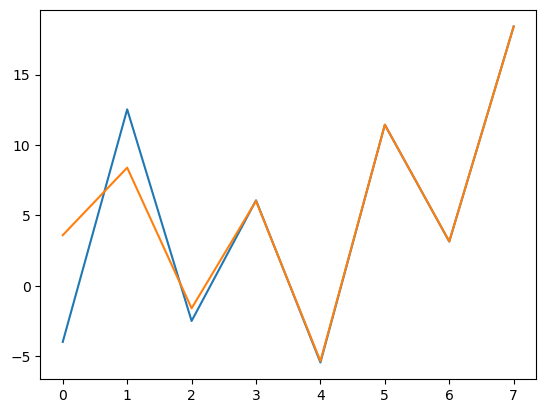

In [29]:
x_foo = torch.zeros((5,1,8))
foo_encoding = PositionalEncoding(8, 0, 100)
x_foo_enc = foo_encoding(x_foo)
#print(x_foo_enc.shape)
#plt.plot(np.squeeze(x_foo_enc[0:5,0,:]).t())

foo_emb = torch.nn.Embedding(4, 8)
#x_faa = torch.empty((2,10))
x_faa = torch.LongTensor([[1,0,1,0,1,0,1,0,3],[0,1,0,1,0,1,0,1,3]])
print(x_faa.shape)
#input = torch.LongTensor([[1, 2, 2, 2], [3, 3, 3, 3]])
#x_faa[0,:] = torch.tensor([2,1,0,1,0,1,0,1,0,3])
#x_faa[1,:] = torch.tensor([2,0,1,2,120,1,3,1,3])
x_faa_emb = foo_emb(x_faa)
print(x_faa_emb.shape)
x_faa_enc = foo_encoding(x_faa_emb).detach()
print(x_faa_enc.shape)
plt.plot(np.squeeze(torch.sum(x_faa_enc,axis=1)).t())
#.tinputlt.plot(np.squeeze(x_faa_enc[1,0,:]).t())

Transformer without masks

In [125]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/p/c80afbc9ffb1/
    """
    # Constructor
    def __init__(
        self,
        num_tokens,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=5000
        )
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)

    def forward(
        self,
        src,
        tgt,
    ):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        # we permute to obtain size (sequence length, batch_size, dim_model),
        src = src.permute(1, 0, 2)
        tgt = tgt.permute(1, 0, 2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt)
        out = self.out(transformer_out)

        return out

#### Transformer model

In [10]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(
        self,
        num_tokens,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=5000
        )
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
        
        # We could use the parameter batch_first=True, but our KDL version doesn't support it yet, so we permute
        # to obtain size (sequence length, batch_size, dim_model),
        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)
        
        return out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)

Training loop

In [37]:
def train_loop(model, opt, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.train()
    total_loss = 0
    
    for batch in dataloader:

        X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        
        # Get mask to mask out the next words
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_input, tgt_mask=tgt_mask)

        # Permute pred to have batch size first again
        pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [12]:
def validation_loop(model, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Get mask to mask out the next words
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            # Standard training except we pass in y_input and src_mask
            pred = model(X, y_input, tgt_mask)

            # Permute pred to have batch size first again
            pred = pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [33]:
def predict(model, input_sequence, max_length=15, SOS_token=2, EOS_token=3):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    model.eval()
    
    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        pred = model(input_sequence, y_input, tgt_mask)
        
        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()

Construct transformer

In [94]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(
    num_tokens=4, dim_model=8, num_heads=1, num_encoder_layers=1, num_decoder_layers=1, dropout_p=0.1
).to(device)
#model = Transformer(
#    num_tokens=4, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1
#).to(device)
#opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

Test without training

In [67]:
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[2, 1, 1, 1, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 0, 0, 0, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    #torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    #torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    #torch.tensor([[2, 0, 0, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    #torch.tensor([[2, 1, 1, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    #torch.tensor([[2, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 1, 1, 1, 3]], dtype=torch.long, device=device)
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [1, 1, 1, 1, 0, 1, 0, 1]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 1
Input: [0, 0, 0, 0, 1, 1, 1, 1]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 2
Input: [1, 1, 1, 1]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



Train N epochs

In [95]:
#num_of_epohcs = 100
#warmup_steps = 10
#model_dims = 8
#
#sche_milestones = np.zeros(num_of_epochs)
#sche_
#
#for step in range(num_of_epochs):
#    print(np.power(model_dims,-0.5)*np.min([np.power(step,-0.5),step*np.power(warmup_steps,-1.5)]))
#
#opt = torch.optim.SGD(model.parameters(), lr=0.01)
#scheduler = torch.nn.lr_scheduler.MultiStepLR(opt, milestones=[500], gamma=0.1)

opt = torch.optim.Adam(model.parameters(), lr=0.01)
#sched = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[20, 40, 60], gamma=0.093)
#sched = ScheduledOptim(opt, lr_mul=1.0, d_model=8, n_warmup_steps=10)

In [99]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []
    
    print("Training and validating model")
    for epoch in range(epochs):
        
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        
        if epoch % 1 == 0:
            print(f'   Epoch {epoch+1} training loss {train_loss:.4f} (lr={opt.param_groups[0]["lr"]})')
            #print("-"*25, f"Epoch {epoch + 1}","-"*25)
            #print(f"Training loss: {train_loss:.4f}")
            #print(f"Validation loss: {validation_loss:.4f}")
            #print()
        #sched.step_and_update_lr()
        #sched.step()
    return train_loss_list, validation_loss_list
    
train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 10)

Training and validating model
   Epoch 1 training loss 0.4629 (lr=0.01)
   Epoch 2 training loss 0.4654 (lr=0.01)
   Epoch 3 training loss 0.4704 (lr=0.01)
   Epoch 4 training loss 0.4856 (lr=0.01)
   Epoch 5 training loss 0.4721 (lr=0.01)
   Epoch 6 training loss 0.4507 (lr=0.01)
   Epoch 7 training loss 0.4636 (lr=0.01)
   Epoch 8 training loss 0.4818 (lr=0.01)
   Epoch 9 training loss 0.4659 (lr=0.01)
   Epoch 10 training loss 0.4753 (lr=0.01)


Test trained model

In [100]:
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[2, 1, 1, 1, 1, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 0, 0, 0, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    #torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    #torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    #torch.tensor([[2, 0, 0, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    #torch.tensor([[2, 1, 1, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    #torch.tensor([[2, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 1, 1, 1, 3]], dtype=torch.long, device=device)
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [1, 1, 1, 1, 0, 0, 0, 0]
Continuation: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

Example 1
Input: [0, 0, 0, 0, 1, 1, 1, 1]
Continuation: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

Example 2
Input: [1, 1, 1, 1]
Continuation: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]



0.0
0.0316227766016838
0.0632455532033676
0.09486832980505139
0.1264911064067352
0.15811388300841897
0.14433756729740646
0.1336306209562122
0.12500000000000003
0.11785113019775792


/tmp/ipykernel_202057/1437381521.py:2: RuntimeWarning: divide by zero encountered in power
  print(np.power(8,-0.5)*np.min([np.power(step,-0.5),step*np.power(5,-1.5)]))
